<h2 style="color:#f0b904">Setting up API Conection</h2>

In [1]:
import qiskit

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from dotenv import load_dotenv
import os

dotenv_path = "../.env"
load_dotenv(dotenv_path)
api_key = os.getenv("IBM_API_KEY")
if api_key is None:
    raise ValueError("API key not found in .env file")

# Save the API key to the Qiskit runtime service, further calls to the service will use this key
QiskitRuntimeService.save_account(
    token=api_key,
    overwrite=True,
    channel="ibm_quantum",
    )
api_key = None # Clear the API key from memory, good practice

service = QiskitRuntimeService()


<h1 style="color:#f0b904"> Ex 1: Querying Backend availability </h1>

<ul>
<li>qiskit.IBMQ (Part of qiskit-terra):
    
    Used to manage access to IBM Quantum cloud-based similators and Quantum devices
    IBMQ is now deprecated (Kinda).
</li>
<br>
<li>qiskit_ibm_runtime:
    
    This is the new way of accessing the IBM quantum services.
    Since IBMQ is deprecated we will be using this module instead.
</li>
</ul>



In [3]:
operational_backends = service.backends(operational=True)

qback = []
sback = []

for b in operational_backends:
    status = b.status()
    if b.simulator:
        sback.append(f"\t{(b.name + ':'):<20} Queue: {status.pending_jobs:5}  Qbits: {b.num_qubits:3}")
    else:
        qback.append(f"\t{(b.name + ':'):<20} Queue: {status.pending_jobs:5}  Qbits: {b.num_qubits:3}")

print("Quantum Devices:")
if len(qback) == 0:
    print("\tNo quantum devices available")
else:
    for b in qback:
        print(b)
print("\nSimulators:")
if len(sback) == 0:
    print("\tNo simulators available")
else:
    for b in sback:
        print(b)


Quantum Devices:
	ibm_brisbane:        Queue:   122  Qbits: 127
	ibm_kyiv:            Queue:   436  Qbits: 127
	ibm_sherbrooke:      Queue:   223  Qbits: 127

Simulators:
	No simulators available


<h1 style="color:#f0b904">Ex 2: Superposition</h1>
<p>Here we have to put a single Qbit in a superposition state, meaning that it's state is in-between 2 energy levels.
<br>Its state will thus become probabilistic/random and not fixed.
<br>This is done through a Hadamard gate:</p>




The Hadamard gate is represented as:
$$
\mathbf{H} = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$

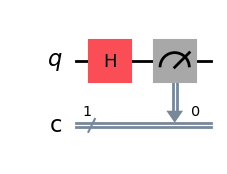

In [4]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(1, 1)

qc.h(0)
qc.measure(0, 0)
qc.draw(output="mpl")

In [5]:
from qiskit.quantum_info import Statevector
#from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator

saer = AerSimulator()

shot_count = 500
qc_aer = qiskit.transpile(qc, backend=saer)
result = saer.run(qc_aer, shots=shot_count).result()
counts = result.get_counts()
print(counts)

counts['0'] = counts['0'] / shot_count
counts['1'] = counts['1'] / shot_count
print(f"Pr 0: {counts['0']:.4f}  Pr 1: {counts['1']:.4f}")


{'1': 249, '0': 251}
Pr 0: 0.5020  Pr 1: 0.4980


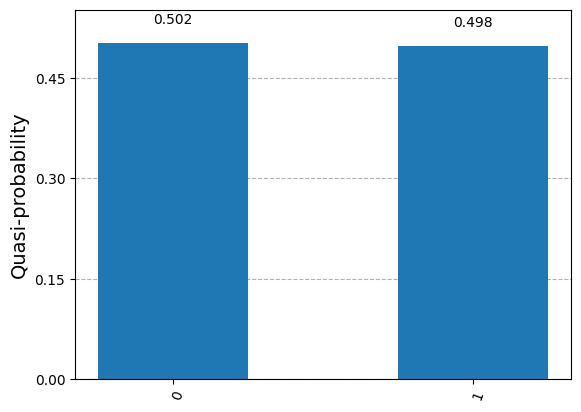

In [6]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)


<h1 style="color:#f0b904">Ex 3: Entanglement</h1>
<p>In Quantum mechanics a group of particules (Qbits in our case) is said to be Entangled if they are linked such that the colapse of one particules will collapse all of them, this is the exact phenomenon that makes Quantum-Computing somewhat useful</p>

<p>In this exercise we have to Entangle 2 Qbits and measure their <i>bell-state</i></p>

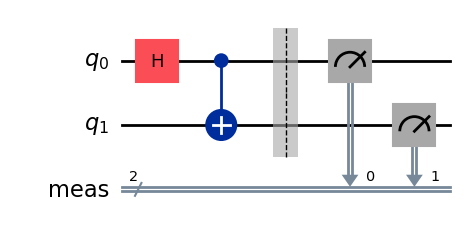

In [7]:
qc = QuantumCircuit(2, 0)

qc.h(0)
# qc.h(1)
qc.cx(0, 1) # Apply CNOT to qbits 1 with 0 as control, meaning if q0 = 1, flip q1
qc.measure_all()
qc.draw(output="mpl")

In [8]:
qc_aer = qiskit.transpile(qc, backend=saer)
result = saer.run(qc_aer, shots=shot_count).result()
counts = result.get_counts()
print(counts)
print(result)

{'11': 247, '00': 253}
Result(backend_name='aer_simulator', backend_version='0.15.0', qobj_id='', job_id='10b8c03b-47dc-4d00-a3f5-dacbd238bd02', success=True, results=[ExperimentResult(shots=500, success=True, meas_level=2, data=ExperimentResultData(counts={'0x3': 247, '0x0': 253}), header=QobjExperimentHeader(creg_sizes=[['meas', 2]], global_phase=0.0, memory_slots=2, n_qubits=2, name='circuit-168', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=3566966509, metadata={'time_taken': 0.000837271, 'num_bind_params': 1, 'parallel_state_update': 8, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000179699, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 15678, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}, time_taken=0

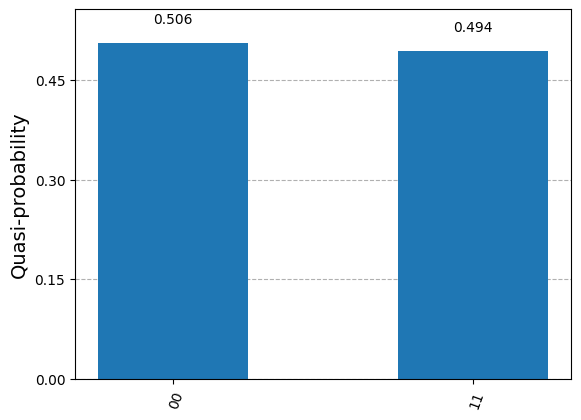

In [9]:
from qiskit.visualization import plot_histogram

for key in counts:
    counts[key] = counts[key] / shot_count
plot_histogram(counts)


We here have a 2 circuit Qbits, first we put q0 in a superposition state using an H-gate as before.<br>
And now we want to entangle the q1 with q0, for this we use a CX (CNOT) gate, which will effectively entangle them.<br>
Now each measurment will collapse both state at the same time.

<h1 style="color:#f0b904">Ex 4: Noise</h1>

<p>Here we will have to set-up the circuit to be run on an Actual IBM quantum computer instead of using a local simulator</p>

In [10]:
from qiskit import transpile

qc = QuantumCircuit(2, 2)

qc.h(0)
qc.cx(0, 1) # Apply CNOT to qbits 1 with 0 as control, meaning if q0 = 1, flip q1
qc.measure(0, 0)
qc.measure(1, 1)
qc.draw(output="mpl")

# Check the queue and take the best one
backend_name = 'ibm_brisbane'
backend = service.backend(backend_name)
# Transpile the circuit, aka, compile it for the specific Quantum device you are gonna use
qc_transpiled = transpile(qc, backend=backend, optimization_level=1)

print(f"Transpiling complete")

Transpiling complete


In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

shots=500

# Re compute if needed
#sampler = Sampler(mode=backend)
#job = sampler.run([qc_transpiled])
#job_id = job.job_id()
#print(f"Job Id: {job_id}")

# Pre-computed: cvaatqtsgfsg008e7bqg
job = service.job('cvaatqtsgfsg008e7bqg')

result = job.result()
print("Job Done")


Job Done


Result: {'11': 237, '00': 241, '01': 17, '10': 5}


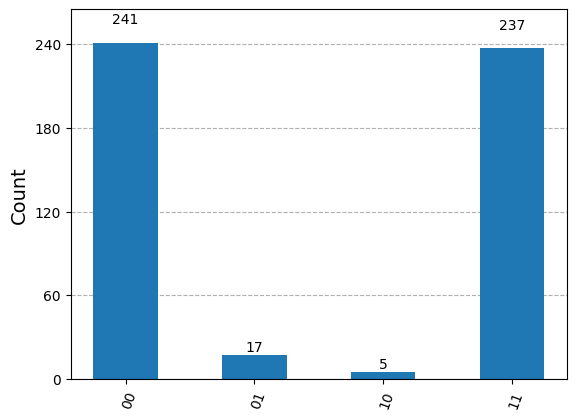

In [12]:

counts = result[0].data.c.get_counts()
print(f"Result: {counts}")
plot_histogram(counts)
